### Import Dependencies

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib notebook

### Read the files

In [53]:
msp_data = pd.read_csv("CMO_MSP_Mandi.csv")
monthly_data_cmo = pd.read_csv("Monthly_data_cmo.csv")

In [54]:
### Undersanding MSP data
print(msp_data.head())
print()
print("The shape of data frame is : ",msp_data.shape)
print()
print("There are total {0} type of crops : ".format(len(msp_data.Type.unique())),msp_data.Type.unique())
print()
print("The data is for {0} years : ".format(len(msp_data.year.unique())),msp_data.year.unique())
print()
print("The are total {0} commodities :  ".format(len(msp_data.commodity.unique())))
print(pd.DataFrame(msp_data.commodity.value_counts()))


         commodity  year          Type  msprice  msp_filter
0   PADDY-UNHUSKED  2012  Kharif Crops   1250.0           1
1  RICE(PADDY-HUS)  2012  Kharif Crops   1280.0           1
2     Jowar_Hybrid  2012  Kharif Crops   1500.0           1
3    SORGUM(JAWAR)  2012  Kharif Crops   1520.0           1
4            BAJRI  2012  Kharif Crops   1175.0           1

The shape of data frame is :  (155, 5)

There are total 3 type of crops :  ['Kharif Crops' 'Rabi Crops' 'Other Crops']

The data is for 5 years :  [2012 2013 2014 2015 2016]

The are total 32 commodities :  
                        commodity
Ragi_Maldandi                   5
Gram_Yellow                     5
SPILT GERRN GRAM                5
SAFFLOWER                       5
RICE(PADDY-HUS)                 5
PADDY-UNHUSKED                  5
SORGUM(JAWAR)                   5
Jowar_Hybrid                    5
WHEAT(HUSKED)                   5
NIGER-SEED                      5
PIGEON PEA (TUR)                5
WHEAT(UNHUSKED)        

In [55]:
print(msp_data[(msp_data["commodity"]=="SUGAR-CANE") | (msp_data["commodity"]=="SUGARCANE") ])
### We can see Sugarcane has been mispelled as Sugar-CANE and SUGARCANE
msp_data_1 = msp_data.copy()
msp_data_1.commodity = msp_data.commodity.replace("SUGAR-CANE","SUGARCANE")
msp_data_1.to_csv('CMO_MSP_MANDI_cleaned.csv')

      commodity  year         Type  msprice  msp_filter
30   SUGAR-CANE  2012  Other Crops    170.0           1
61   SUGAR-CANE  2013  Other Crops    210.0           1
92   SUGAR-CANE  2014  Other Crops    220.0           1
123  SUGAR-CANE  2015  Other Crops    230.0           1
154   SUGARCANE  2016  Other Crops    230.0           1


In [56]:
## Lets convert all commodity names to lower case
msp_data_2 = msp_data_1.copy()
msp_data_2.commodity = msp_data_2.commodity.str.lower()
msp_data_2.to_csv('CMO_MSP_MANDI_cleaned.csv')

In [57]:
## Converting Commidity to lower case
monthly_data_cmo_1 = monthly_data_cmo.copy()
monthly_data_cmo_1.Commodity = monthly_data_cmo_1.Commodity.str.lower()
monthly_data_cmo_1.Commodity = monthly_data_cmo_1.Commodity.replace({'maize(corn.)':'maize (corn.)',
                                                                    'soybean':'soyabean',
                                                                    'kardai' : 'safflower',
                                                                    'sarsav' : 'mustard',
                                                                    'nachani' : 'ragi_maldandi'})

monthly_data_cmo_1.to_csv('Monthly_data_cmo_cleaned.csv')

In [59]:
## We merge the entries for same APMC and Commodity for a same date
### The resason for this anomaly is not yet clear, But i assume this is an error in data collection
monthly_data_cmo_2 = monthly_data_cmo_1.groupby(['state_name','district_name','APMC','Commodity','Year','Month','date'])\
    .agg({
    'arrivals_in_qtl' : 'sum',
    'min_price' : 'min',
    'max_price' : 'max',
    'modal_price' : 'mean'
}).reset_index()
monthly_data_cmo_2.head()
monthly_data_cmo_2.to_csv('Monthly_data_cmo_cleaned.csv')

In [60]:
### understanding monthly mandi price
print(monthly_data_cmo_2.head(2))
print()
print("The shape of data frame is : ",monthly_data_cmo_2.shape)
print()
print("There are total {0} Districts  ".format(len(monthly_data_cmo_2.district_name.unique())))
print()
print("There are total {0} APMC  ".format(len(monthly_data_cmo_2.APMC.unique())))
print()
print("There are total {0} Commodities  ".format(len(monthly_data_cmo_2.Commodity.unique())))
print()


    state_name district_name        APMC Commodity  Year      Month     date  \
0  Maharashtra    Ahmadnagar  Ahmednagar     bajri  2014   November  2014-11   
1  Maharashtra    Ahmadnagar  Ahmednagar     bajri  2014  September  2014-09   

   arrivals_in_qtl  min_price  max_price  modal_price  
0              395       1507       1750       1629.0  
1               24       1400       1750       1575.0  

The shape of data frame is :  (62387, 11)

There are total 33 Districts  

There are total 349 APMC  

There are total 201 Commodities  



### Adjust Prices For Inflation

In [61]:
## Read Consumer Index File
cpi_data = pd.read_csv('All_India_Index_April-2018.csv')
columns_to_keep = ['Sector','Year','Month','General index']
cpi_data = cpi_data[columns_to_keep]
cpi_data = cpi_data[cpi_data['Sector']=='Rural']
cpi_data.drop(columns='Sector',inplace=True)
cpi_data.set_index(['Year','Month'],inplace=True)

cpi_data.head()

General index
Year Month                  
2013 January           105.1
     February          105.8
     March             106.0
     April             106.4
     May               107.2

In [62]:
min_price_adjusted = []
max_price_adjusted = []
modal_price_adjusted = []

for index,row in monthly_data_cmo_2.iterrows():
    
    year = row['Year']
    month = row['Month']
    index = cpi_data.loc[(year,month),'General index']
    min_price_adjusted.append(row['min_price']*index/100)
    max_price_adjusted.append(row['max_price']*index/100)
    modal_price_adjusted.append(row['modal_price']*index/100)
    
monthly_data_cmo_3 = monthly_data_cmo_2.copy()
monthly_data_cmo_3['min_price_adjust'] = min_price_adjusted
monthly_data_cmo_3['max_price_adjust'] = max_price_adjusted
monthly_data_cmo_3['modal_price_normalised'] = modal_price_adjusted
    
monthly_data_cmo_3.head()
monthly_data_cmo_3.to_csv('Monthly_data_cmo_cleaned.csv')

## Filtering Outliers

In [63]:
monthly_data_cmo_4 = monthly_data_cmo_3\
    .assign(
    q1_apmc_date_comm=monthly_data_cmo_3.groupby(['Commodity','date']).modal_price_normalised.transform(np.percentile,q=25),
    q3_apmc_date_comm=monthly_data_cmo_3.groupby(['Commodity','date']).modal_price_normalised.transform(np.percentile,q=75)
)

outliers = []
for index,row in monthly_data_cmo_4.iterrows():
    modal_price = row['modal_price_normalised']
    q1 = row['q1_apmc_date_comm']
    q3 = row['q3_apmc_date_comm']
    iqr = q3-q1
    if((modal_price > q3 + 1.5 * iqr) or (modal_price < q1 - 1.5 * iqr) ):
        outliers.append(True)
    else:
        outliers.append(False)

        
monthly_data_cmo_4['outlier'] = outliers
monthly_data_cmo_4.head()
monthly_data_cmo_4.to_csv('Monthly_data_cmo_cleaned.csv')

### According to this we have 5 % outliers
#### We can closely examine these values and further reduce this number
##### For now we remove all the outlier values

In [64]:
monthly_data_cmo_5 = monthly_data_cmo_4[monthly_data_cmo_4.outlier==False]
monthly_data_cmo_5.to_csv('Monthly_data_cmo.csv')

#### Testing out assumptions about the data

In [65]:
## Assumption is there are equal mandis in all Districts
monthly_data_cmo_5.district_name.value_counts()

Pune          5866
Ahmadnagar    4458
Nagpur        4243
Solapur       4130
Nasik         3495
Satara        2632
Buldhana      2612
Amaravathi    2506
Jalgaon       2465
Aurangabad    2244
Beed          1860
Osmanabad     1676
Thane         1583
Kolhapur      1557
Mumbai        1553
Jalna         1456
Latur         1372
Yewatmal      1371
Dhule         1266
Parbhani      1246
Chandrapur    1163
Akola         1056
Sangli        1031
Nanded        1018
Wasim          949
Nandurbar      935
Hingoli        752
Wardha         620
Raigad         587
Bhandara       519
Ratnagiri      399
Gadchiroli     343
Gondiya        125
Name: district_name, dtype: int64

<IPython.core.display.Javascript object>


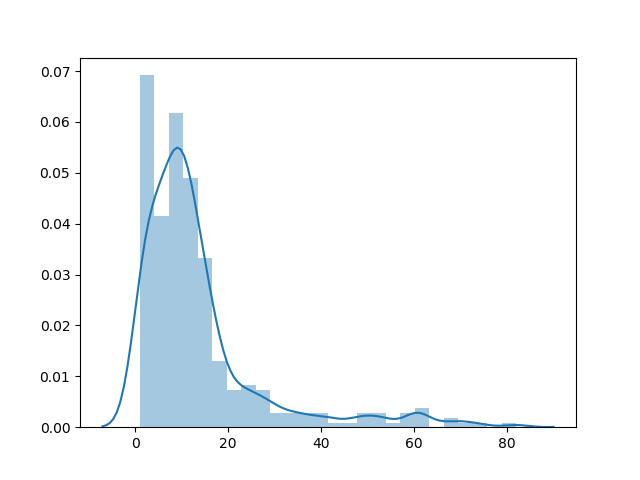

C:\Users\Admin\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


In [66]:
def count_unique(data):
    return len(set(data))

### All mandis have all the commodities 
mandi_commodity_count = pd.DataFrame(monthly_data_cmo_5.groupby('APMC').Commodity.unique())

count = []
for index,row in mandi_commodity_count.iterrows():
    count.append(len(row['Commodity']))

monthly_data_cmo_5 = monthly_data_cmo_5.assign(
    mandi_size = pd.cut(
        monthly_data_cmo_5.groupby('APMC').Commodity.transform(count_unique),labels=['small','medium','large'],bins=[-0.1,10,40,100] ))

plt.figure()
sns.distplot(count)
plt.show()

# We can see that this graph is positively skewed
#### This shows that there are more small mandis as compared to large mandis

<IPython.core.display.Javascript object>


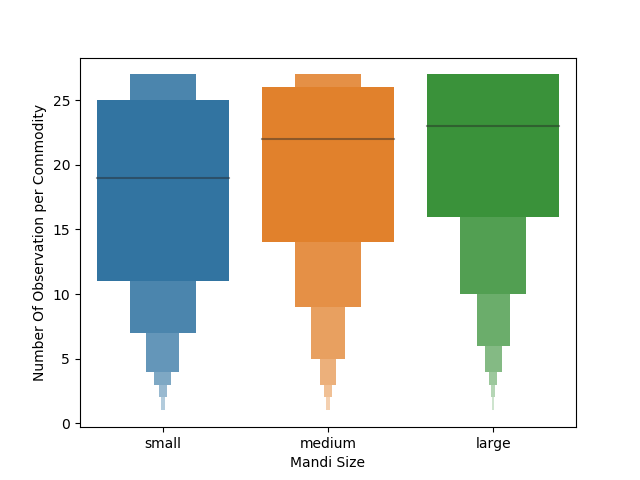

In [67]:
## All Combination of mandi and commodities have same number of months data
monthly_data_cmo_5 = monthly_data_cmo_5.assign(date_count = monthly_data_cmo_5.groupby(['APMC','mandi_size','Commodity']).date.transform('count'))

plt.figure()
ax = sns.boxenplot(data= monthly_data_cmo_5,x='mandi_size',y='date_count')
ax.set_ylabel('Number Of Observation per Commodity')
ax.set_xlabel('Mandi Size')
plt.show()


### For the purpose of this analysis i only select those APMC_Mandi which have atleast 20 observations

In [68]:
## Now We are left with only 122 Commodities
monthly_data_cmo_6 = monthly_data_cmo_5[monthly_data_cmo_5['date_count']>=20].drop('mandi_size',axis=1)


from datetime import datetime
def convert_to_date(date_str):
    return datetime.strptime(date_str,'%Y-%m').date()

date_list = pd.date_range(start='2014-09-01',end='2016-11-01',freq='MS').date

monthly_data_cmo_6.date = monthly_data_cmo_6.date.apply(convert_to_date)

temp = monthly_data_cmo_6.set_index(['state_name','district_name','APMC','Commodity'])

missing_dates_data = []

date_com_mean = monthly_data_cmo_6.groupby(['date','Commodity']).mean()
for index,row in temp.groupby(level=[0,1,2,3]):
    dates = row['date'].values
  
    missing_dates = [date for date in date_list if date not in dates]

    
    for date in missing_dates:
        if (date,index[3]) in date_com_mean.index:
            missing_dates_data.append(index+(date.year,date.month,date)+tuple(date_com_mean.loc[(date,index[3])][1:]))
            
        else:
            missing_dates_data.append(index+(date.year,date.month,date,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan))
  
        
     

monthly_data_cmo_7 = monthly_data_cmo_6.append(pd.DataFrame(data= missing_dates_data,columns=monthly_data_cmo_6.columns))
monthly_data_cmo_7 = monthly_data_cmo_7.fillna(method='ffill')
monthly_data_cmo_7.head()
monthly_data_cmo_7.to_csv('Monthly_data_cmo_cleaned.csv')

### Currently we have used ffill a more suitable way would be to use the average of the previous and the next month.
#### But for now we leave it to the next iteration

### Let us detect the seasonality type of each APMC-Comm

The data provided has been collected for only two years, it is difficult to identify the seasonality type with visual inspection or statistical test.

My approach was to try both additive and multiplicative methods, keep the one which has less autocorelation after deseasonalising.

For Now, i have assumed that all seasonalities are additive in nature, and used Holt Winter's method for deseasonalizing the prices.

Also we do not account for trend because it is very difficult to get general trend with just two years of data.

In [ ]:
from seasonal import fit_seasons, adjust_seasons

monthly_data_cmo_8 = monthly_data_cmo_7.sort_values(by=['district_name','APMC','Commodity','date'])\
    .set_index(['state_name','district_name','APMC','Commodity'])


adjusted_modal_price = []

for index,row in monthly_data_cmo_8.groupby(level=[0,1,2,3]):
    row = row.reset_index()
    temp = row[['date','modal_price_normalised']]
    temp['date'] = pd.to_datetime(temp['date'])
    temp  = temp.set_index('date')
    seasons,trend = fit_seasons(temp.modal_price_normalised)
   
    
    adjusted = temp.modal_price_normalised.values
    
    if seasons is not None:
        adjusted = adjust_seasons(list(temp.modal_price_normalised.values),seasons=seasons) 
   
    adjusted_modal_price = adjusted_modal_price+(adjusted.tolist())
    
monthly_data_cmo_9 = monthly_data_cmo_8.copy()
monthly_data_cmo_9['adjusted_modal_price'] = adjusted_modal_price    
monthly_data_cmo_9.to_csv('Monthly_data_cmo_cleaned.csv')

C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
def coeff_of_var(x):
    if np.mean(x)==0:
        return x
    
    return np.var(x) / np.mean(x)

c_var_APMC_comm = []

for index,row in monthly_data_cmo_9.groupby(level=[0,1,2,3]):
    temp = list(index) + [coeff_of_var(row.modal_price_normalised)]
    c_var_APMC_comm.append(temp)

c_var_APMC_comm = pd.DataFrame(columns=['state_name','district_name','APMC','Commodity','c_var'],data=c_var_APMC_comm)
c_var_APMC = c_var_APMC_comm.groupby('APMC').agg({'c_var':'mean'})
temp = monthly_data_cmo_9.reset_index()
c_var_comm = temp.groupby(['Commodity','date']).agg({'adjusted_modal_price' : coeff_of_var}).reset_index().groupby('Commodity').mean()
c_var_comm.columns = ['c_var']

c_var_average_comm = c_var_APMC_comm.groupby('Commodity').agg({'c_var':'mean'})

def is_higVar(row):
    if row[0] <=q1:
        return -1
    else:
        if (row[0] >=q3):
            return 1
        else:
            return 0
q1,q3 = c_var_APMC.c_var.quantile(q=[0.25,0.75])
c_var_APMC['is_HighVarAPMC'] = c_var_APMC.c_var >q3
c_var_APMC['is_LowVarAPMC'] = c_var_APMC.c_var <q1


q1,q3 = c_var_comm.c_var.quantile(q=[0.25,0.75])
c_var_comm['is_HighVarComm'] = c_var_comm.c_var >q3
c_var_comm['is_LowVarComm'] = c_var_comm.c_var <q1

q1,q3 = c_var_APMC_comm.c_var.quantile(q=[0.25,0.75])
c_var_APMC_comm['is_HighVarAPMCComm'] = c_var_APMC_comm.c_var >q3
c_var_APMC_comm['is_LowVarAPMCComm'] = c_var_APMC_comm.c_var <q1

monthly_data_cmo_10 = monthly_data_cmo_9.reset_index().set_index(['APMC','Commodity']).copy()\
.join(c_var_APMC_comm.set_index(['APMC','Commodity'])[['is_HighVarAPMCComm','is_LowVarAPMCComm']],on=['APMC','Commodity'])\
.reset_index()\
.join(c_var_APMC[['is_HighVarAPMC','is_LowVarAPMC']],on=['APMC'])\
.set_index('Commodity')\
.join(c_var_comm[['is_HighVarComm','is_LowVarComm']])

### Counts of Commdity Types


In [ ]:
fig,(ax1,ax2,ax3) = plt.subplots(nrows=1,ncols=3,figsize=(12,8))

In [ ]:
fig,(ax1,ax2,ax3) = plt.subplots(nrows=1,ncols=3,figsize=(12,8))
sns.boxenplot(c_var_APMC.c_var,ax=ax1)
ax1.set_title('Coeff. of Var of APMC')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)


sns.boxenplot(c_var_comm.c_var,ax=ax2)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.set_title('Coeff. of Var of Comm.')


sns.boxenplot(c_var_APMC_comm.c_var,ax=ax3)
ax3.set_title('Coeff. of Var of Comm. in APMC')
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['left'].set_visible(False)
plt.show()

In [ ]:
## Custom Created Crop grouping
main_comm_grouping = pd.read_csv('main_commodity.csv')
main_comm_grouping.dropna(inplace=True,subset=['Commodity'])
main_comm_grouping.MSP.fillna(inplace=True,value=False)
c_var_average_comm_2 = c_var_average_comm.join(main_comm_grouping.set_index('Commodity') )
plt.figure()
sns.boxplot(data = c_var_average_comm_2[(c_var_average_comm_2['Crop Type - Season']=='Kharif Crops')|(c_var_average_comm_2['Crop Type - Season']=='Rabi Crops')]
            ,y='c_var',x='Crop Type - Season',orient='v')
plt.show()



We can see that Rabi Crops show more variation then Kharif Crops.

In [ ]:
plt.figure()
sns.boxplot(data = c_var_average_comm_2[(c_var_average_comm_2['Crop Type - Season']=='Kharif Crops')|(c_var_average_comm_2['Crop Type - Season']=='Rabi Crops')]
            ,y='c_var',x='MSP',orient='v')
plt.show()

We can clearly see that there is much less varition for crops for which we have the MSP declared. But this could be due the fact that there are very less commodities for which the MSP has been declared.

In [ ]:
plt.figure()
sns.boxplot(data=c_var_APMC.join(monthly_data_cmo_5[['APMC','mandi_size']].drop_duplicates().set_index('APMC'),
               on='APMC'),x='mandi_size',y='c_var')
plt.show()

We can see that larger mandi show greater variation in price, but again we can attribute this to the fact thre are more crops in larger mandis.

In [ ]:
cpi_data_2 = cpi_data.reset_index().groupby('Year').agg({'General index':'mean'})
msp_data_3 = msp_data_2.sort_values(by=['commodity','year']).fillna(method='ffill')
msp_adjusted = []
for index,row in msp_data_3.iterrows():
 
    year = row['year']
    if year ==2012:
        index =100
    else:
        index = cpi_data_2.loc[year,'General index']
    msp_adjusted.append(row['msprice']*index/100)
       
msp_data_4 = msp_data_3.copy()
msp_data_4['msp_normalised'] = msp_adjusted
msp_data_4.commodity.replace({
    'ragi_maldandi':'ragi'
},inplace=True)

msp_data_4.rename(columns={
    'commodity':'Commodity',
    'year':'Year'
},inplace=True)
monthly_data_cmo_10 = monthly_data_cmo_9.reset_index().set_index(['Commodity','Year'])\
    .join(msp_data_4.set_index(['Commodity','Year']))



In [ ]:
mean_error_adjusted_price = (np.abs(monthly_data_cmo_10.adjusted_modal_price -monthly_data_cmo_10.msp_normalised)/monthly_data_cmo_10.msp_normalised).dropna()
mean_error_adjusted_price = mean_error_adjusted_price.groupby('Commodity').mean().sort_values(ascending=False)

mean_error_normalised_price = (np.abs(monthly_data_cmo_10.modal_price_normalised -monthly_data_cmo_10.msp_normalised)/monthly_data_cmo_10.msp_normalised).dropna()
mean_error_normalised_price = mean_error_normalised_price.groupby('Commodity').mean().sort_values(ascending=False)

In [ ]:
mean_square_error =pd.DataFrame(mean_error_normalised_price).join(pd.DataFrame(mean_error_adjusted_price),lsuffix='normalised',rsuffix='adjusted')
mean_square_error.columns = ['mean_error_normalised','mean_error_adjusted']
mean_square_error

In [ ]:
monthly_data_cmo_11 = monthly_data_cmo_10.reset_index().copy()

plt.figure()
sns.lineplot(data=monthly_data_cmo_11[monthly_data_cmo_11['Commodity']=='split black gram'].sort_values(by='date'),
            x='date',
            y='modal_price',
            label='Split Black Gram')
sns.lineplot(data=monthly_data_cmo_11[monthly_data_cmo_11['Commodity']=='mustard'].sort_values(by='date'),
            x='date',
            y='modal_price',
            label='Split Black Gram')
plt.show()

## Now we can compare the demand and supply for commodities

In [ ]:
corelation = []
for index,row in monthly_data_cmo_11.set_index(['APMC','Commodity'])[['arrivals_in_qtl','modal_price']].groupby(level=[0,1]):
    corelation.append(list(index)+[row.corr().iloc[0,1]])

corelation = pd.DataFrame(corelation)

In [ ]:
plt.figure()
sns.boxplot(corelation.iloc[:,2],orient='v')
plt.show()

### We can see that for a majority of APMC and comm have negative corelation for demand and supply. 
Also some commodities| have positive corelation. This is a very interesting observation and can be stuided in detail.